In [1]:
#Change directory to data location 
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from scipy import stats

In [4]:
#Read time-event excel data
csevt=pd.read_excel('E:\. Disertasi S3 Bismillah\Olah Data\CS Lim Index V Based Event Data RM3.xlsx')
csevt=csevt.set_index('time_peak')

In [5]:
#Date event CS CENS no CENS (1-->CENS, 0-->no CENS)
n_cens = 2
evt_cens_cs = []
for i in range(n_cens):
    evt_cens = csevt[csevt['censevt'] == i].index
    print("Number of CS {i} = {n} dari {x}".format(i=i, n=len(evt_cens), x=len(csevt)))
    print("Number of CS {i} = {n}%".format(i=i, n=(len(evt_cens)*100/len(csevt.index))))
    evt_cens_cs.append(evt_cens.values)

Number of CS 0 = 127 dari 201
Number of CS 0 = 63.18407960199005%
Number of CS 1 = 74 dari 201
Number of CS 1 = 36.81592039800995%


In [6]:
datamswep = xr.open_mfdataset('E:\Data MSWEP Yearly\MSWEP*',combine = 'by_coords')

In [7]:
#Get the variables
rainms=datamswep['precipitation'].sel(lat=slice(20,-20), lon=slice(90,130), time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000'))
latrainms=rainms['lat'].values
lonrainms=rainms['lon'].values
time=rainms['time'].values

#Slice in NDJFM
rainms=rainms.sel(time=rainms.time.dt.month.isin([1, 2, 3, 11, 12]))
rainms=rainms.rolling(time=3, center=True).mean()

#Calculate clim and rainfall anomalies
climrainms = rainms.sel(time=rainms.time.dt.season=="DJF").mean('time')
anrain = rainms - climrainms

In [8]:
raindjfclim= anrain.load()

In [9]:
#Change CENS and no-CENS array for plot
evt_cens_cs=[evt_cens_cs[1], evt_cens_cs[0]]

In [10]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [11]:
sigmslp=np.empty([2, 5, len(latrainms), len(lonrainms)], dtype='bool')
data=raindjfclim.sel(time=raindjfclim.time.dt.season=="DJF")
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    for d, n in zip([-4,-2,0,2,4], range(5)):
        compositemean=raindjfclim.sel(time=np.in1d(raindjfclim.time, evt_cens_cs[c]+np.timedelta64(d,'D'))).mean(dim='time')
        sigmslp[c, n]=np.logical_or(compositemean<low, compositemean>high).values
pvalueraintf=sigmslp

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.83it/s]


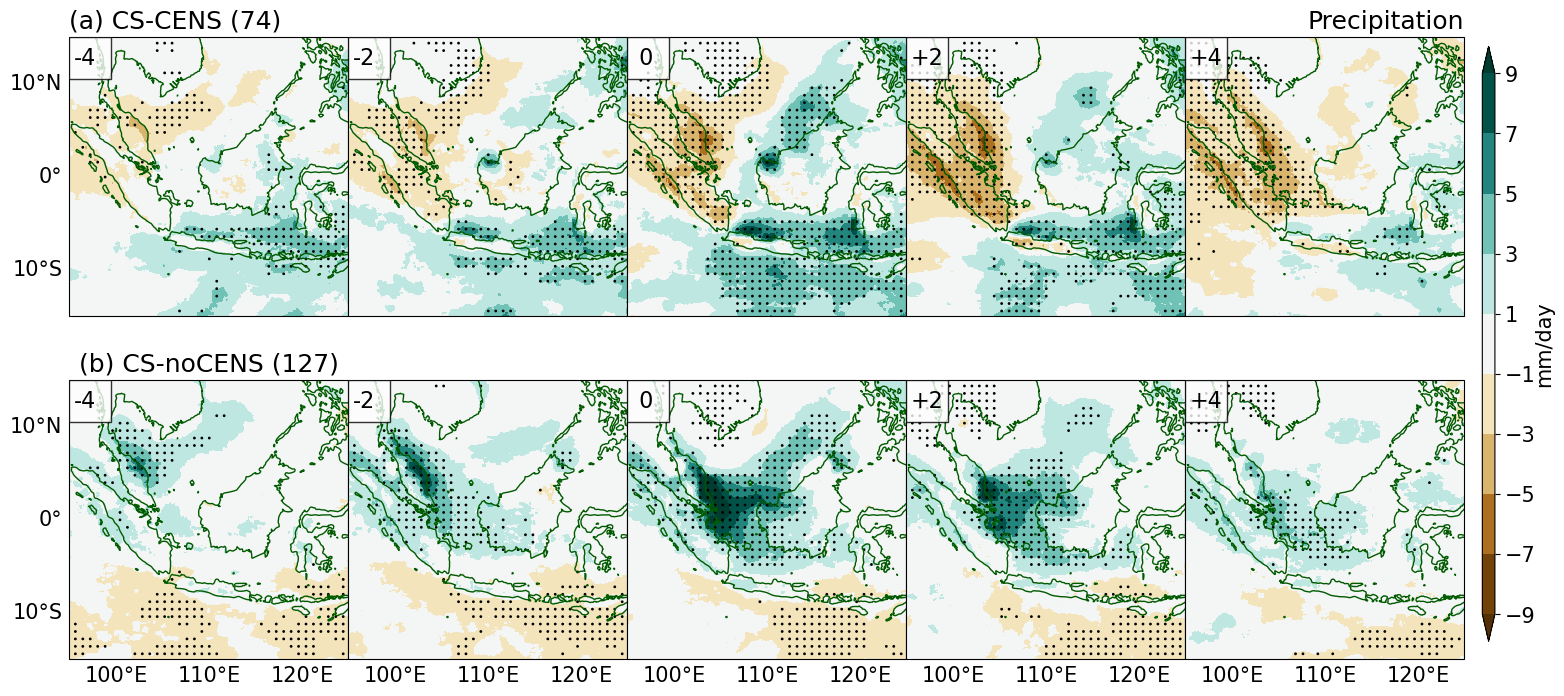

In [12]:
#Plot Rain Composite
fig, axs = plt.subplots(nrows=2,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8.5))

for k in range(2):
    for j, i, text in zip([-4,-2,0,2,4], range(5), ['-4','-2',' 0','+2','+4']):
       
        axs[k,i].set_extent([95, 125, -15, 15])
        gl=axs[k,i].gridlines(draw_labels=True,linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = tk.FixedLocator([100, 110, 120])
        gl.ylocator = tk.FixedLocator([-10, 0, 10])
        gl.xlabel_style = {'size': 15}
        gl.ylabel_style = {'size': 15}
        if k==0:
            gl.bottom_labels = False
        if i>0:
            gl.left_labels = False
        valuetp=raindjfclim.sel(time=np.in1d(raindjfclim.time, evt_cens_cs[k]+np.timedelta64(j,'D'))).mean(dim='time')
        plotvaltp=axs[k,i].contourf(lonrainms, latrainms, valuetp, transform=ccrs.PlateCarree(),
                  cmap='BrBG',
                  levels=np.arange(-9, 10, 2), extend='both'
                  )
        x,y=np.meshgrid(lonrainms, latrainms)
        skipp=8
        axs[k,i].scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvalueraintf[k,i][::skipp,::skipp]*1,color='k', linewidth=1)

        axs[k,i].add_feature(cfeature.COASTLINE, edgecolor='#005a00')
        
        longitude1, latitude1 = 95, 10.5
        longitude2, latitude2 = 99.5, 15

        axs[k,i].add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                        facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                                        transform=ccrs.PlateCarree()))
        
        axs[k,i].text(95.5,12,text,fontsize=16, c='k')
        
        if i==0 and k==0:
            axs[k,i].set_title('(a) CS-CENS ('+str(len(evt_cens_cs[k]))+')', loc='left', fontsize=18,
                    )
        if i==0 and k==1:
            axs[k,i].set_title('(b) CS-noCENS ('+str(len(evt_cens_cs[k]))+')', fontsize=18,
                    )
        if i==4 and k==0:
            axs[k,i].set_title('Precipitation', loc='right', fontsize=18,
                    )

cbar_tp = fig.add_axes([0.91, 0.15, 0.007, 0.7])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp
                     )
cbartp.ax.tick_params(labelsize=15)
cbartp.ax.set_ylabel('mm/day', fontsize=15, labelpad=-1)

fig.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('figure_output\Fig 5.pdf', bbox_inches='tight')
#plt.savefig('E:\. Disertasi S3 Bismillah\Publikasi\Paper Hubungan CS dan CENS\Gambar/g_Rainfall Composite.jpg', dpi=300, bbox_inches='tight')
plt.show()